# Forecasting AI and ML Job Trends with SARIMA

Here, we filter out AI/ML/DS jobs using a Large Language Model (LLM)

**NB**: The cleaned dataset contains 1.2 million job postings. It is beyond the quota limits provided by most LLMS to analyse all these postings at one go. Hence this is just for evaluation and the results of this noebook are not used further in the data processing pipeline

LLM in use: **Gemini**

## Dependencies

In [96]:
import os
import sys
import traceback
import time
import re
from dotenv import load_dotenv
import json
from functools import wraps
import os
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import google.generativeai as genai
from tenacity import (
    retry,
    stop_after_attempt, 
    wait_exponential,
    retry_if_exception_type
)
from google.api_core.exceptions import ResourceExhausted


## Data Loading

Load Environment variables (Includes Gemini API key)

In [62]:
load_dotenv()

True

In [63]:
filename = "data/job_postings_normalized.parquet"
job_postings = pd.read_parquet(filename)

In [64]:
print(f"{len(job_postings):,} job postings loaded from {filename}")
job_postings.sample(5)

1,296,381 job postings loaded from data/job_postings_normalized.parquet


,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count
893895,2024-01-21 13:15:55.907921+00,t,t,f,med surg/telemetry rn (days or nights) at maxi...,health ecareers,"weymouth, ma",2024-01-14,duxbury,united states,companion,mid senior,onsite,"[med surg, telemetry rn, epic, bls, acls, nurs...",8
905060,2024-01-20 08:22:17.049131+00,t,t,f,rn homecare,maxim healthcare services (home care),"millstadt, il",2024-01-14,illinois,united states,companion,mid senior,onsite,"[registered nurse (rn) license, health certifi...",24
681021,2024-01-19 09:45:09.215838+00,t,t,f,duty pharmacy manager - exmouth p/t,tesco,"exmouth, england, united kingdom",2024-01-13,exeter,united kingdom,pharmacist,mid senior,onsite,"[pharmacy degree, leadership, gphc membership,...",13
1025372,2024-01-21 16:23:17.594102+00,t,t,f,senior propulsion controls engineer,nikola corporation,"phoenix, az",2024-01-14,peoria,united states,controls designer,mid senior,onsite,"[matlab/simulink, control software development...",27
702524,2024-01-19 09:45:09.215838+00,t,t,f,cable installer,jobs for humanity,"marysville, oh",2024-01-13,ohio,united states,installer,mid senior,onsite,"[aptitude, communication, customer service, el...",16


## Rate Limiter Set up

In [89]:
class QuotaTracker:
    def __init__(self, rpm_limit=14, daily_limit=1400):
        self.rpm_limit = rpm_limit
        self.daily_limit = daily_limit
        self.state_file = "data/llm/config/quota_state.json"
        os.makedirs(os.path.dirname(self.state_file), exist_ok=True)
        self.load_state()
        
    def load_state(self):
        if os.path.exists(self.state_file):
            with open(self.state_file, 'r') as f:
                state = json.load(f)
                # Convert ISO strings to timestamps
                self.minute_calls = [
                    datetime.fromisoformat(ts).timestamp() 
                    for ts in state.get('minute_calls', [])
                ]
                self.daily_calls = [
                    datetime.fromisoformat(ts).timestamp() 
                    for ts in state.get('daily_calls', [])
                ]
        else:
            self.minute_calls = []
            self.daily_calls = []
    
    def save_state(self):
        state = {
            'minute_calls': [
                datetime.fromtimestamp(ts).isoformat() 
                for ts in self.minute_calls
            ],
            'daily_calls': [
                datetime.fromtimestamp(ts).isoformat() 
                for ts in self.daily_calls
            ]
        }
        with open(self.state_file, 'w') as f:
            json.dump(state, f)
    
    def check_quota(self):
        now = datetime.now().timestamp()
        
        # Clean old timestamps
        minute_ago = now - 60
        day_ago = now - 86400
        
        self.minute_calls = [ts for ts in self.minute_calls if ts > minute_ago]
        self.daily_calls = [ts for ts in self.daily_calls if ts > day_ago]
        
        if len(self.minute_calls) >= self.rpm_limit:
            wait_time = 61 - (now - min(self.minute_calls))
            print(f"Rate limit: {len(self.minute_calls)}/{self.rpm_limit} requests this minute")
            return False, int(wait_time)
        
        if len(self.daily_calls) >= self.daily_limit:
            wait_time = 86400 - (now - min(self.daily_calls))
            print(f"Daily limit: {len(self.daily_calls)}/{self.daily_limit} requests today")
            return False, int(wait_time)
            
        return True, 0
    
    def add_call(self):
        now = datetime.now().timestamp()
        self.minute_calls.append(now)
        self.daily_calls.append(now)
        self.save_state()

## Model Set up

Set up Gemini LLM Model

In [90]:
def get_llm_model():
    gemini_api_key = os.getenv('GEMINI_API_KEY')

    if not gemini_api_key:
        raise ValueError("Please set the GEMINI_API_KEY environment variable")

    genai.configure(api_key=gemini_api_key)
    model = genai.GenerativeModel("gemini-1.5-flash")
    
    print(f"LLM model loaded successfully: `{model.model_name}`")

    return model

llm = get_llm_model()

LLM model loaded successfully: `models/gemini-1.5-flash`


Construct a proper prompt to use

In [91]:
def construct_prompt(job_description):
    return f"""
        Does this job description indicate skills related to Artificial Intelligence, Machine Learning, 
        or Data Science, including techniques like deep learning, computer vision, natural language processing,
        predictive modeling, or data analysis, and tools/frameworks such as TensorFlow, PyTorch, or scikit-learn? 
        
        Job Description: {job_description}
        
        Return response in this exact JSON format:
        {{
            "likelihood": <number 0-10>,
            "reason": "<concise explanation>"
        }}
        """

Utility to assign likelihood for job postings using gemini
- Incliudes retry logic for Gemini API rate limits.

In [92]:
@rate_limited
def classify_with_gemini(model, job_description):
    try:
        prompt = construct_prompt(job_description)
        response = model.generate_content(prompt)

        json_match = re.search(r"```json\n(.*?)\n```", response.text, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group(1))
            return result["likelihood"], result["reason"]
        else:
            print(f"Could not find JSON in response: {response.text}")
            return -1, "Failed to extract JSON from response"
        
    except ResourceExhausted as e:
        print(f"Hit API quota limit: {e}")
        sys.exit(1)  # Exit gracefully on quota exhaustion
    except Exception as e:
        print(f"Error: {e}")
        print(traceback.format_exc())
        return -1, str(e)

## Likelihood Assignment using LLM

Classify jobs using LLM in batches with checkpointing.

In [93]:
def get_chunk_files(checkpoint_dir):
    """Get list of existing chunk files sorted by chunk number."""
    import glob
    chunk_files = glob.glob(f"{checkpoint_dir}/chunk_*.parquet")
    return sorted(chunk_files)

def get_next_chunk_number(checkpoint_dir):
    """Determine next chunk number to process."""
    chunk_files = get_chunk_files(checkpoint_dir)
    if not chunk_files:
        return 0
    last_chunk = chunk_files[-1]
    return int(last_chunk.split('_')[-1].split('.')[0]) + 1

Process jobs in batches, saving each as separate chunk file.

In [94]:
def classify_jobs_with_llm(df, model, checkpoint_dir, batch_size):
    
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Determine starting point
    chunk_number = get_next_chunk_number(checkpoint_dir)
    start_index = chunk_number * batch_size
    
    if start_index >= len(df):
        print("All chunks processed")
        return pd.concat([pd.read_parquet(f) for f in get_chunk_files(checkpoint_dir)])
        
    print(f"Starting from chunk {chunk_number} (index {start_index})")
    
    try:
        for i in range(start_index, len(df), batch_size):
            # Process batch
            batch = df.iloc[i:i+batch_size].copy()
            batch['gemini_likelihood'] = 0
            batch['gemini_reason'] = ""
            
            for index, row in batch.iterrows():
                skills_str = ", ".join(row['job_skills'])
                job_desc = f"{row['job_title']} {row['search_position']} {row['company']} {skills_str}"
                likelihood, reason = classify_with_gemini(model, job_desc)
                
                batch.loc[index, 'gemini_likelihood'] = likelihood
                batch.loc[index, 'gemini_reason'] = reason
                
                # print(f"Processed job {index}")
            
            # Save chunk
            chunk_file = f"{checkpoint_dir}/chunk_{chunk_number:04d}.parquet"
            batch.to_parquet(chunk_file)
            print(f"Saved chunk {chunk_number}")
            chunk_number += 1
            
        # Combine all chunks
        combined_chunk_files = pd.concat([pd.read_parquet(f) for f in get_chunk_files(checkpoint_dir)])
        print(f"Processed {len(combined_chunk_files):,} jobs")
        
        return pd.concat([pd.read_parquet(f) for f in get_chunk_files(checkpoint_dir)])
        
    except Exception as e:
        print(f"Error processing chunk {chunk_number}: {e}")
        return None

In [ ]:
checkpoint_dir = "data/llm/chunks"
os.makedirs(checkpoint_dir, exist_ok=True)

classify_jobs_with_llm(
    job_postings,
    llm,
    checkpoint_dir=checkpoint_dir,
    batch_size=10,
)

print("All job postings classified with LLM")

## LLM Classification review

Load and combine all processed chunks into single DataFrame

In [97]:
def load_processed_chunks(checkpoint_dir='data/llm/chunks'):
    try:
        # Ensure directory exists
        if not os.path.exists(checkpoint_dir):
            raise FileNotFoundError(f"Checkpoint directory not found: {checkpoint_dir}")
            
        # Get all chunk files sorted numerically
        chunk_files = sorted(
            glob.glob(f"{checkpoint_dir}/chunk_*.parquet"),
            key=lambda x: int(x.split('_')[-1].split('.')[0])
        )
        
        if not chunk_files:
            raise FileNotFoundError("No chunk files found")
            
        # Load and concatenate all chunks
        chunks = []
        for file in chunk_files:
            chunk = pd.read_parquet(file)
            chunks.append(chunk)
            
        # Combine all chunks
        combined_df = pd.concat(chunks, axis=0)
        print(f"Loaded {len(chunk_files)} chunks with {len(combined_df)} total records")
        
        return combined_df
        
    except Exception as e:
        print(f"Error loading chunks: {e}")
        return None

In [98]:
processed_chubks = load_processed_chunks()

Loaded 99 chunks with 990 total records


In [99]:
processed_chubks.sample(5)

,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,gemini_likelihood,gemini_reason
863,2024-01-21 08:08:47.40795+00,t,t,f,"sr category manager, capex","cps, inc.","dayton, il",2024-01-14,sheridan,united states,buyer,mid senior,onsite,"[strategic development, procurement oversight,...",11,1,"The job description focuses on procurement, ca..."
378,2024-01-20 13:46:15.66326+00,t,t,f,sous chef - culinary,reynolds lake oconee,"greensboro, ga",2024-01-15,georgia,united states,butcher apprentice,mid senior,onsite,"[leadership, training, motivation, serve safe ...",8,0,The job description is for a culinary position...
616,2024-01-19 15:57:45.5226+00,t,t,f,"travel icu rn job in pleasant prairie, wi - ma...",aya healthcare,"pleasant prairie, wi",2024-01-14,newport,united states,recruiter,mid senior,onsite,"[icu, registered nurse, 1+ year experience, ni...",19,0,The job description is for an ICU Registered N...
330,2024-01-21 07:12:53.311726+00,t,t,f,rn- hospice at ssm health,health ecareers,"st louis, mo",2024-01-16,ferguson,united states,pattern hand,mid senior,onsite,"[nursing, medical assessment, care planning, p...",20,1,The job description focuses on nursing skills ...
777,2024-01-21 08:08:31.941595+00,t,t,f,senior etl data warehouse specialist,adame services llc,"new york, ny",2024-01-14,middletown,united states,technical support specialist,associate,onsite,"[etl, data integration, data transformation, d...",27,3,The job description focuses heavily on ETL (Ex...


In [ ]:
processed_chubks[processed_chubks['gemini_likelihood'] > 0]['gemini_likelihood'].value_counts().sort_index()

gemini_likelihood
1     511
2      92
3      45
4       9
7       3
8       3
9       1
10      3
Name: count, dtype: int64

Review the distribution of the likelihood count

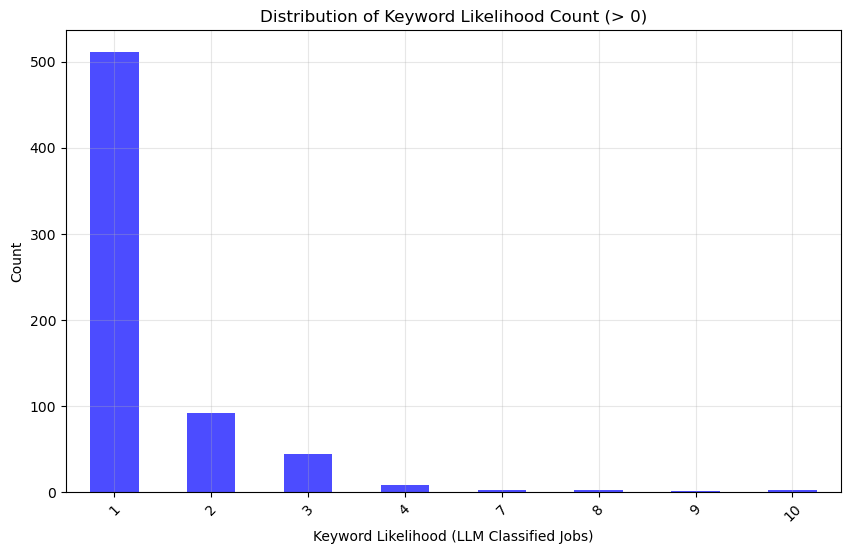

In [101]:
likelihood_distribution = (
    processed_chubks[processed_chubks["gemini_likelihood"] > 0]["gemini_likelihood"]
    .value_counts()
    .sort_index()
)
# print(likelihood_distribution)


plt.figure(figsize=(10, 6))
likelihood_distribution.plot(kind="bar", color="blue", alpha=0.7)
plt.title("Distribution of Keyword Likelihood Count (> 0)")
plt.xlabel("Keyword Likelihood (LLM Classified Jobs)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()